# 20160308 - CHO ChR2 Marta experiment

In [2]:
import sys
# include the toolkit path in the modules paths
sys.path.append('../scripts')

# graphics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from IPython.html.widgets import interact

# maths
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit, minimize, leastsq

# the opsin-model toolkit
import marco_tools as mt

import quantities as pq

# plotting constants
FIG_BIG = (15,10)
FIG_H = (15,7)
FIG_SMALL = (7,7)

# help setting the text in a plot
def default_plot_setup(title='Title', xlabel='x',ylabel='y'):
    plt.title(title);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);


/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# ExperimentFolder is an object that looks for experiment files in a given folder
folder = mt.ExperimentFolder("../experimental/160225_CHO_ChR2_Marta/", file_extension='abf')
filename = folder.file_names_as_string_list
print filename

# ExperimentFile is an object that loads data from a CSV file
# efile = mt.ExperimentFile(folder.folder, filename)

['2016_02_25c_0005.abf']


/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/quantities/quantity.py:379: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.magnitude == other


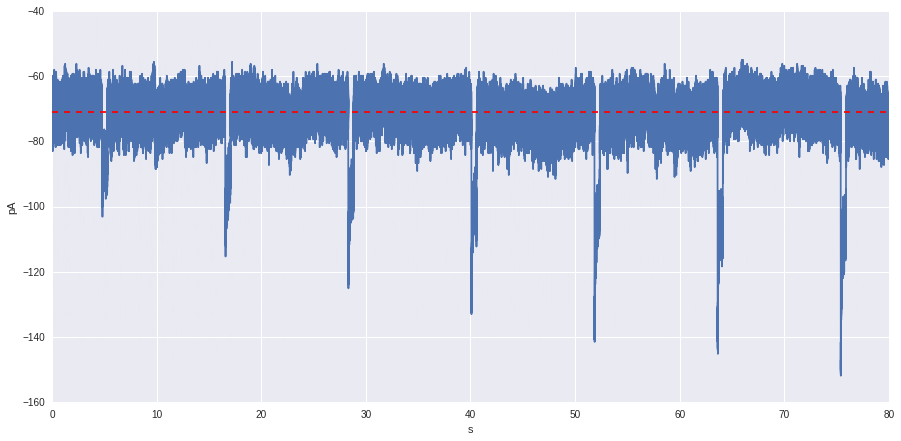

In [3]:
plt.figure(figsize=FIG_H)
f = mt.ABFExperimentFile(folder.folder+filename[0])
xdata, ydata = f.import_data(block=0, segment=0, signal=0)
e = mt.OpsinExperiment(ydata, xdata=xdata)

# e.set_data_density(100, mean_between_steps=True)
# e.select_by_data_points(800,950)
# e.smoothing(100)
e.select_by_time(0,80)
# e.x.sumstract_min()
# e.convert_x('ms')
#e.plot('.')
resting_potential = np.mean(e.y[e.y>-90])
e.plot((e.x[0],e.x[-1]),(resting_potential,resting_potential),'r--')

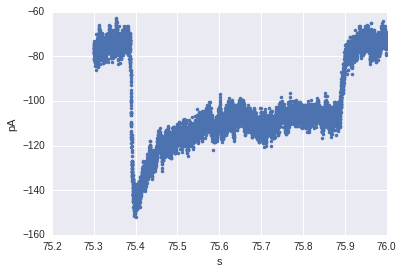

In [15]:
a = 75.3
b = 76
e.convert_x('s')
e.select_by_time(a,b)
e.plot('.')

a *= 1000
b *= 1000

<function __main__.f>

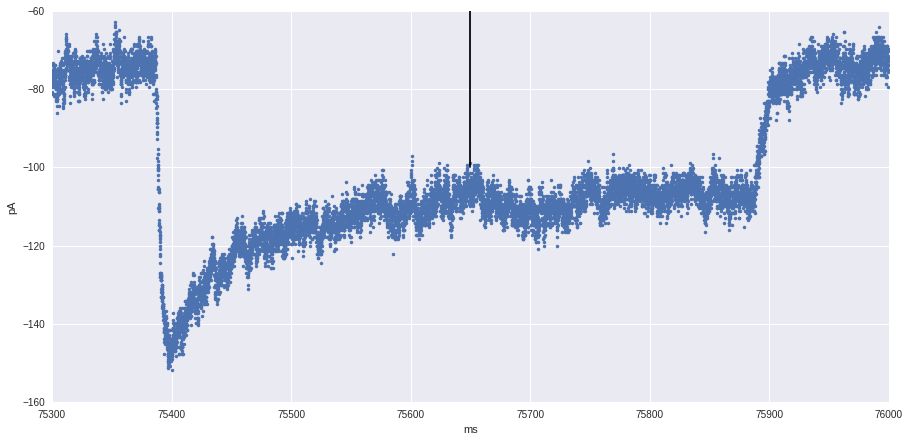

In [16]:
e.convert_x('ms')
e.select_by_time(a,b)

def f(x):
    plt.figure(figsize=FIG_H)
    e.plot('.')
    plt.plot((x,x),(-60,-100),'k')

interact(f,x=(a,b,1))


In [4]:
# power values [what unit?] what spot surface?
powervalues_slidebook = np.array([
        5,
        10,
        15,
        20,
        25,
        30,
        35,
])

# power measured under the objective with 5um spot [mW]
powervalues = pq.Quantity(np.array([
        0.174,
        0.37,
        0.58,
        0.8,
        0.94,
        1.23,
        1.45
    ]), pq.mW)


# cell area
cell_area = pq.Quantity(111,pq.um**2) # um2
power_density = (powervalues/cell_area)
# 

# powervalues = powervalues[::-1]
powervalues = power_density.magnitude ### to adapt to the real illumination surface

print power_density

[ 0.00156757  0.00333333  0.00522523  0.00720721  0.00846847  0.01108108
  0.01306306] mW/um**2


In [5]:
pulse_start_times = [
    4788,
    16553,
    28314,
    40081,
    51849,
    63616,
    75385
]
### End time of light pulse for each powercurve
# pulse_end_times = np.array([
# 225,215,205,195,185,175,165,155,135
# ])

assert len(pulse_start_times) == len(powervalues_slidebook)

exps = mt.ExperimentCollection()
fname = filename[0]
for i in range(len(pulse_start_times)):
    ### OPEN ABF FILE AND CREATE OPSIN EXPERIMENT INSTANCE
    f = mt.ABFExperimentFile(folder.folder+fname)
    xdata, ydata = f.import_data(block=0, segment=0, signal=0)
    e = mt.OpsinExperiment(ydata, xdata=xdata) 
 
    ### CONVERT THE TIME AXIS TO MILLISECONDS
    e.convert_x('ms')

    ### SELECT THIS PULSE
    TBIS = 500 ### Time Before Impulse START
    TAIS = 1000 ### Time After Impulse START
    e.select_by_time(pulse_start_times[i]-TBIS, pulse_start_times[i]+TAIS)

    ### SET INITIAL TIME TO ZERO
    e.change_x_reference(pulse_start_times[i])
#     e.resampled_data_x = e.resampled_data_x - temp
       
    ### SET THE APPROPRIATE PULSE START TIME
    # e.pulse_start = pulse_start_times[i]
    e.pulse_start = 0
    e.pulse_end = 500
    
    
    ### SUBSTRACT THE RESTING POTENTIAL
#     e.y.substract_constant(resting_potential)

 
    ### INVERT THE DATA
    e.y.invert()
    
    ### SUBSTRACT MEAN OF PRE-PULSE DATA
    e.y.substract_mean(start_x=-TBIS, end_x=-10)
    
    ### SET THE EXPERIMETN LABEL AS ITS POWER
    e.label = powervalues_slidebook[i]
      
    ### set the laser pulse start and end time  
    # e.pulse_end = pulse_end_times[i]
    
    ### Overwrite data
    e.select_by_time(-50,1000)
    e.update_raw_data_from_current()
    
    exps.append(e)

print "Done"

Done


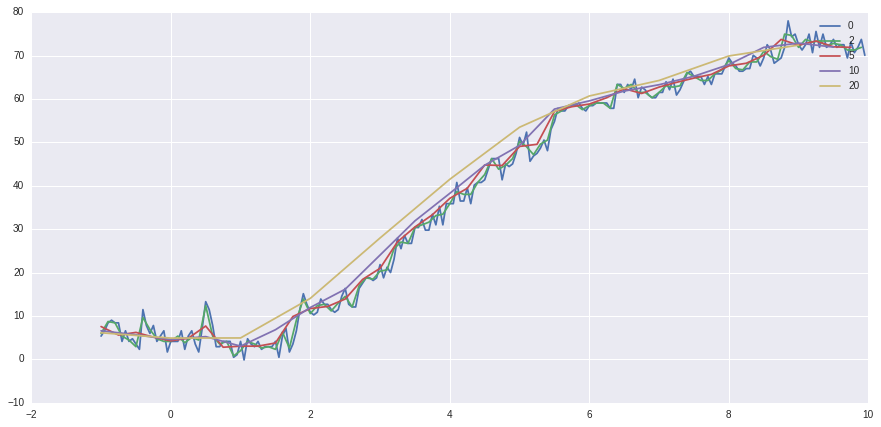

In [8]:
### RESAMPLING EFFECT
plt.figure(figsize=FIG_H)

e.reset_current_to_raw_data()
e.select_by_time(-1,10)

i = 0
plt.plot(e.x,e.y,'-',label=i)

for i in [2,5,10,20]:
    e.reset_current_to_raw_data()
    e.resample(i)
    plt.plot(e.x,e.y,'-',label=i)


plt.legend()

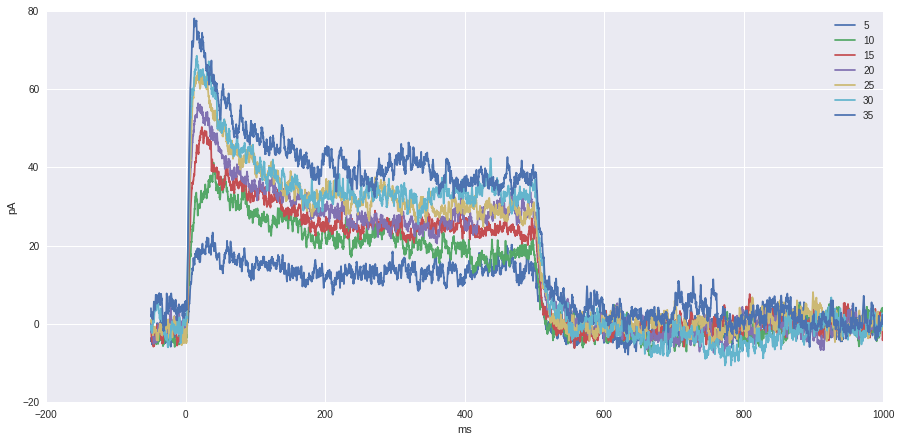

In [33]:
### PLOT
plt.figure(figsize=FIG_H)

for e in exps:
    e.reset_current_to_raw_data()
    e.smoothing(10)

    e.plot()
    plt.legend()
    e.reset_current_to_raw_data()
    

/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/scipy/optimize/minpack.py:601: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


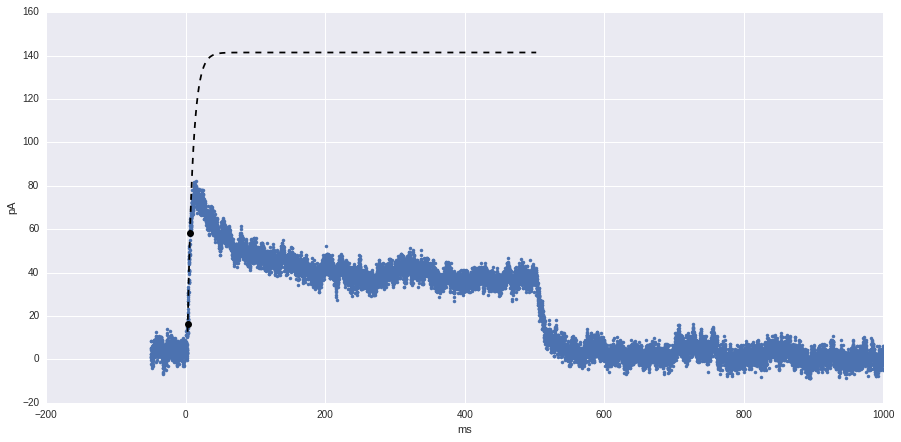

In [6]:
plt.figure(figsize=FIG_H)

e.plot('.')
### OpsinFit is an object that helps fitting these parameters.
fit = mt.OpsinFit(e)
fit.fit_parameter("max_current", start_fit_time=2.5, end_fit_time=6)
fit_result = fit.model("max_current")
bnd = fit.fit_bnds("max_current")
norm_param = fit.max_current

# plt.plot(np.linspace(0,500,100),[norm_param]*100,'--',label="max current in a two level system = {}".format(int(round(norm_param))));
plt.plot(fit_result[0],fit_result[1],'k--',label="exponential fit of the highest power curve")
plt.plot(bnd[0],bnd[1],'ko')

# plt.legend();

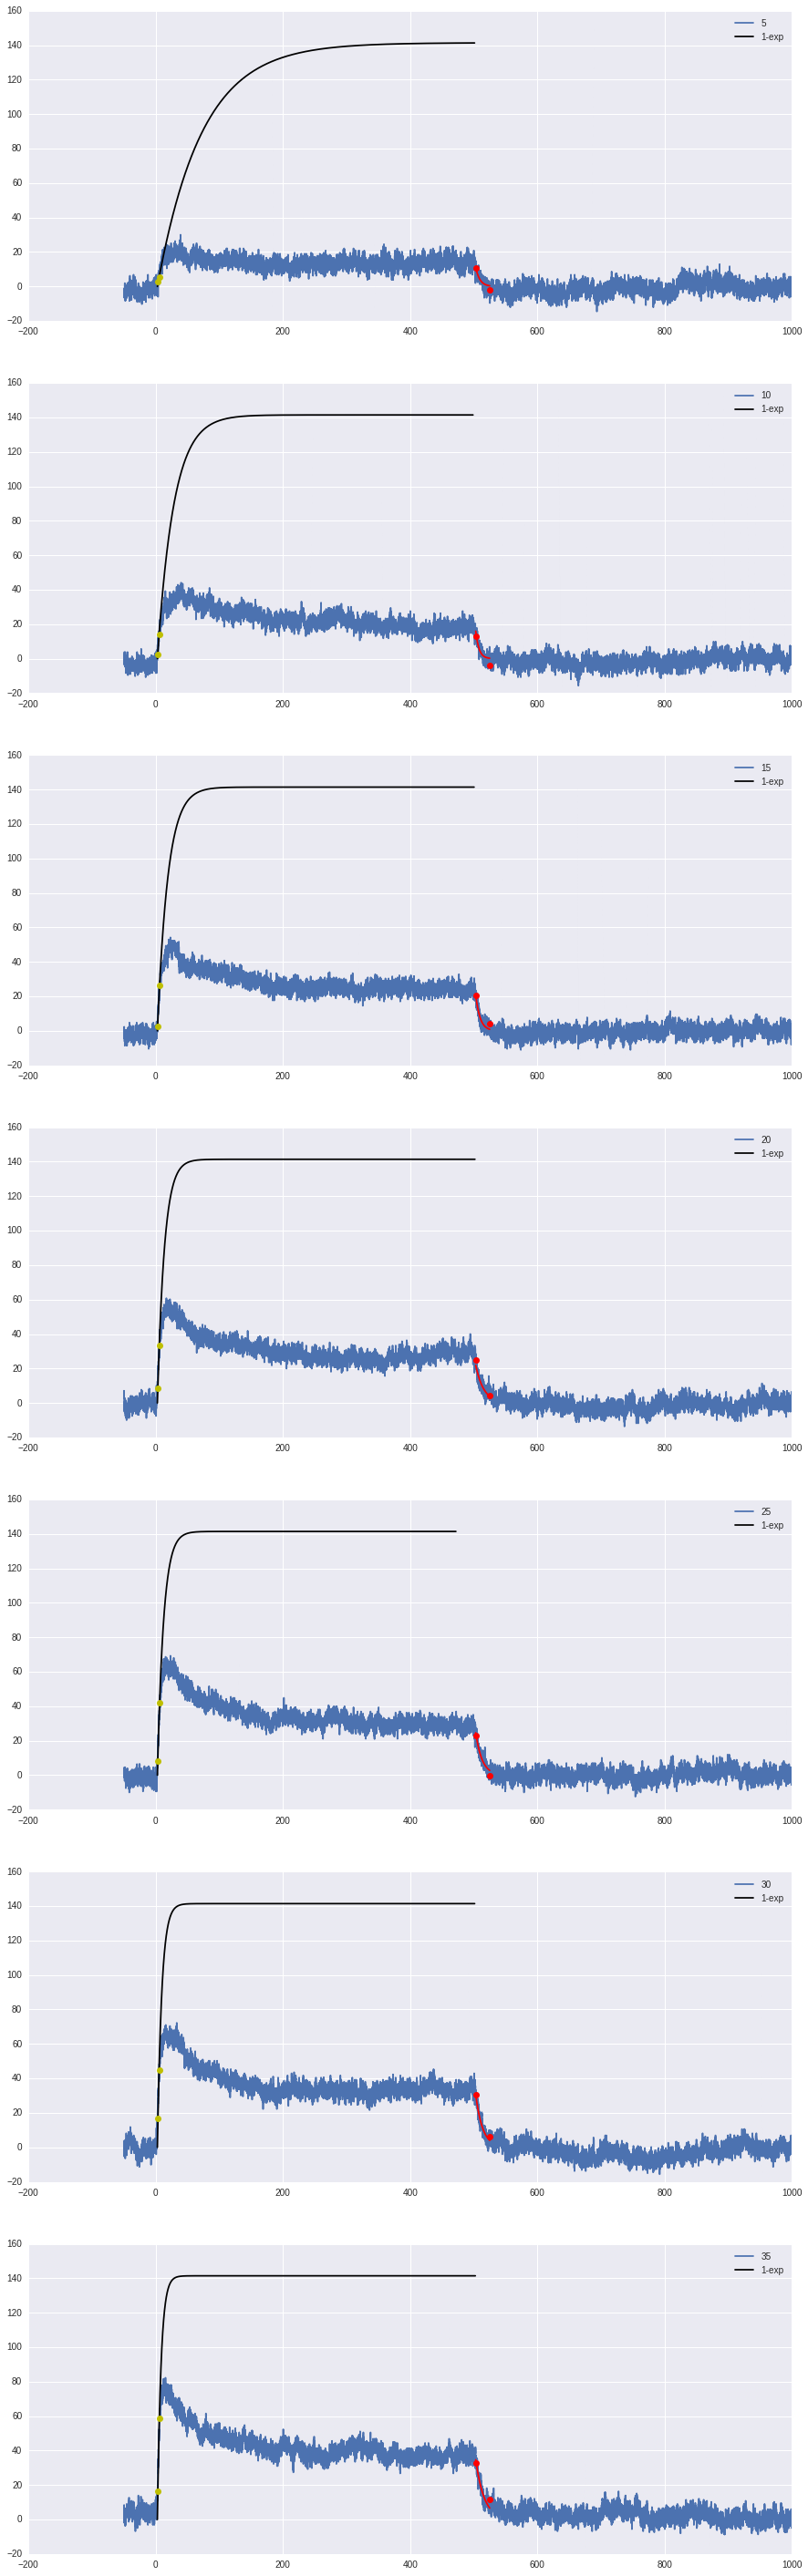

media tau_off 9.33764144685
media tau_on 20.8475091992


In [7]:
plt.figure(figsize=(15,50))

plots = len(exps)
cols = 1
rows = plots/cols + plots%cols

pulse_end_times = []
tau_ons = []
tau_offs = []
sstate = []

for i,e in enumerate(exps):
  
    # fit tau_on and tau_off
    fit.e = e
    fit.fit_parameter("tau_on", start_fit_time=2.5,end_fit_time=6)
    fit.fit_parameter("tau_off", start_fit_time=503, end_fit_time=525)
    
    pulse_end_times.append(e.pulse_end)

    
    tau_ons.append(fit.tau_on)
    tau_offs.append(fit.tau_off)

    # theoretical statdy state
    k_on = 1.0/fit.tau_on
    k_off = 1.0/fit.tau_off
    sst = k_on/(k_on+k_off)*norm_param
    sstate.append(sst)
    
    
    plt.subplot(rows,cols,i+1)
    # default_plot_setup(title= 'power= ' + str(round(e.light_power,3)),xlabel='',ylabel='')

    plt.plot(e.x, e.y, label=e.label )
    plt.plot(fit.model("tau_off")[0],fit.model("tau_off")[1],'r')
    plt.plot(fit.model("tau_on")[0],fit.model("tau_on")[1],'k', label="1-exp")
    plt.plot(fit.fit_bnds("tau_off")[0],fit.fit_bnds("tau_off")[1],'ro')
    plt.plot(fit.fit_bnds("tau_on")[0],fit.fit_bnds("tau_on")[1],'yo')
    #plt.plot(np.linspace(0,500,100),[sst]*100,'--g',label='2 levels steady state')

    plt.legend()

    #plt.axis([0,450,-20,norm_param+10])
    

    
plt.show()
# store the mean value of tau off
tau_off = np.mean(tau_offs)
#tau_on = np.mean(tau_ons)
print "media tau_off", np.mean(tau_offs)
print "media tau_on", np.mean(tau_ons)




## Taus vs light power

Here follows a plot of the values of tau ON and tau OFF that we have just measured, against the light power.

[ 0.10227079]


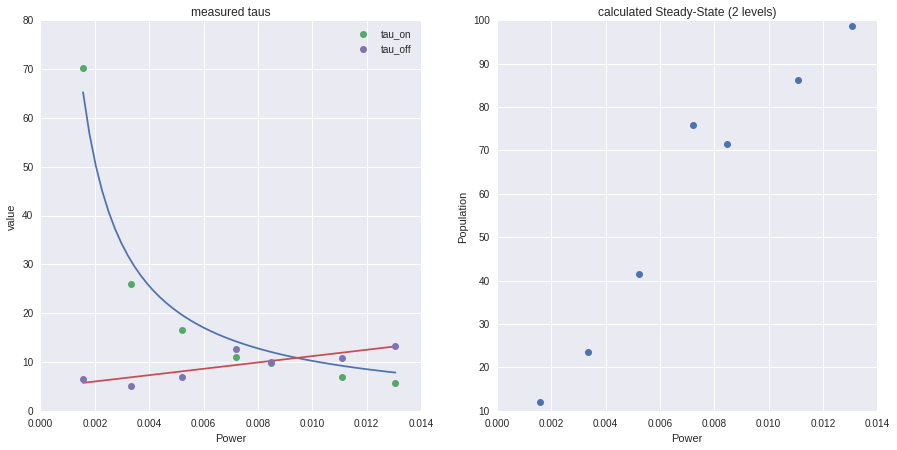

In [8]:
plt.figure(figsize=FIG_H)

x=np.linspace(min(powervalues),max(powervalues))

plt.subplot(1,2,1)
default_plot_setup(title='measured taus',ylabel='value',xlabel='Power')    


# FIT TAU ON

def func_on(x,m):
    return m / x
# This function, fits even better with initial parameters 
# p0=np.array([5.38288476e-02,   1.13175396e-04,   7.79980161e-01, 0])
# but the vertical asymptote is not in x=0, and this is a problem in simulations
# since at low power values one has a discontinuity and negative valules.
# def func_on(x,m,q,c,a):
#     return m / (a*x + q) + c


popt_on, pcov_on = curve_fit(func_on,
                             powervalues,
                             np.array(tau_ons),
                             #p0=np.array([5.38288476e-02,   1.13175396e-04,   7.79980161e-01, 0]),
                            )

plt.plot(x, func_on(x, *popt_on),'-')
plt.plot(powervalues, tau_ons,'o',label='tau_on')
print popt_on
# plt.axis([0,0.1,0,30])




def func_off(x,m,q):
    return m *x + q

popt_off, pcov_off = curve_fit(func_off, powervalues, np.array(tau_offs))
plt.plot(x, func_off(x,popt_off[0],popt_off[1]),'-')
plt.plot(powervalues, tau_offs,'o',label='tau_off')


plt.legend()
# plt.axis([0,0.1,0,50]);
plt.subplot(1,2,2)
default_plot_setup(title='calculated Steady-State (2 levels)',xlabel='Power',ylabel='Population')  
plt.plot(powervalues,sstate,'o');

def func_sstate(x,a,b,c):
    # see how tau_on depends on light power and the formula of 2 level steady state
    return (x+a)/(x+b) + c

try:
    popt, pcov = curve_fit(func_sstate, powervalues, np.array(sstate))
    plt.plot(x, func2(x,popt[0],popt[1],popt[2]),'-')
except:
    pass


In [9]:
# temp = np.linspace(0,0.02)
# plt.plot(temp, func_on(temp, *popt_on));
print "MEAN TAU OFF:",  np.mean(tau_offs)

MEAN TAU OFF: 9.33764144685


* **left** : tau on and tau off with their respective fits
* **right** : steady state current value for a 2 level state with this tau on and off

### Plotting $\tau_{off}$ with its confidence interval

(0, 36)

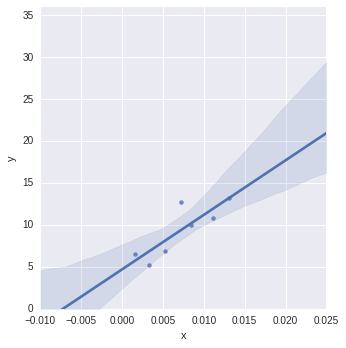

In [10]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame()
df['x'] = powervalues
df['y'] = tau_offs

sns.lmplot('x', 'y', df, ci=95)
plt.ylim((0,36))

# Model fitting

<!-- <img src="imgs/3levels_model.svg" width="30%"> -->

First we define a coefficient matrix.

Each element of this matrix speciefies a transition coefficient (ex. k[O,C] is the coefficient of the transition from Open to Closed state).

Since we use a 3 level system, the matrix dimension is 3x3.

There are 2 of those matrices: k_on and k_off. They contain the values of the transition coefficients when light is on or off respectively.

In [11]:
lightpower = 1

# CONSTANTS DEFINING THE STATES
C = 0   # Closed state
O = 1   # Opens state
D = 2   # Desensitized state

# TRANSITION RATES
K_off = np.zeros([3,3]) # transition coefficient MATRIX when light is OFF
K_on =  np.zeros([3,3]) # transition coefficient MATRIX when light is ON

tau = tau_off #17.9 # usually called "tauoff" [ms] Exp Physiol. 2011 Jan; 96(1): 19–25. 
k = 1.0/tau

#beta = (k*0.7-k/3)/(powervalues[-1]-powervalues[0])# fit parameter
beta = "ciao"

K_off[O,C] = k
K_on[O,C] = k # this transition does not depend on light

#K_off[C,O] = 0
#K_on[C,O] = k

#K_off[O,D] = 0
#K_on[O,D] = lightpower*beta

#K_off[D,O] = k/30
#K_on[D,O] = K_off[D,O] # k/30


# Fitting kd

In [12]:
def func_kd(t,kod,kdc):
#     K_on[O,D] = kod
#     K_off[O,D] = kod
#     K_on[D,C] = kdc
#     K_off[D,C] = kdc
    v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
    return v[:,1]

In [13]:
### THE WORKING FUNCTION
# names = ['Kod','Kdo']
# def func_kd(t,kod,kdo):
#     K_on[O,D] = kod
#     K_off[O,D] = kod
#     K_on[D,O] = kdo
    
#     v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
#     return v[:,1]

### BENOIT's TEST
names = ['Kod','Kdc']
def func_kd(t,kod,kdc):
    K_on[O,D] = kod
    K_off[O,D] = kod
    K_on[D,C] = kdc
    K_off[D,C] = kdc
    v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
    return v[:,1]


popt_kd = np.zeros((len(exps),2))
initial_condition = [norm_param,0,0]

print "WARGING : if measurement errors are not specified,\
confidence intervals do not make much sense\n"
# print "68% CONFIDENCE INTERVALS:"

for i,e in enumerate(exps) :
    
    lightpower = powervalues[i]
    this_tau_on = func_on(lightpower,*popt_on)
    K_on[C,O] = 1.0/this_tau_on
    pulse_duration = e.pulse_end-e.pulse_start
    pulse = mt.Pulse(e.pulse_start,pulse_duration,10000)
    
    popt_kd[i], pcov_kd = curve_fit(func_kd, e.x, e.y, p0=(0.005,0.005))
    

    print "curve %x" % i
    for j,p in enumerate(popt_kd[i]):
        print "{} : {:.2E} +/- {:.2E}".format(names[j], p, np.sqrt(pcov_kd[j,j]))
    print ""


for i in range(popt_kd.shape[1]):
    k_temp = np.mean(popt_kd[:,i])
    print "mean {} : {:.2E},\t tau = {:.2E} ms".format(names[i], k_temp, 1.0/k_temp)


WARGING : if measurement errors are not specified,confidence intervals do not make much sense

curve 0
Kod : 1.14E-02 +/- 1.19E-04
Kdc : 5.61E-03 +/- 3.99E-05

curve 1
Kod : 7.38E-03 +/- 3.37E-05
Kdc : 1.06E-03 +/- 5.51E-06

curve 2
Kod : 1.18E-02 +/- 2.35E-05
Kdc : 4.13E-03 +/- 1.20E-05

curve 3
Kod : 1.38E-02 +/- 5.57E-05
Kdc : 5.12E-03 +/- 3.70E-05

curve 4
Kod : 1.15E-02 +/- 2.83E-05
Kdc : 4.64E-03 +/- 2.27E-05

curve 5
Kod : 1.54E-02 +/- 5.99E-05
Kdc : 6.95E-03 +/- 3.73E-05

curve 6
Kod : 9.73E-03 +/- 3.86E-05
Kdc : 4.99E-03 +/- 3.44E-05

mean Kod : 1.16E-02,	 tau = 8.63E+01 ms
mean Kdc : 4.64E-03,	 tau = 2.15E+02 ms


In [14]:
kod_mean = np.mean(popt_kd[:,0])
kdc_mean = np.mean(popt_kd[:,1])

K_on[O,D] = kod_mean
K_off[O,D] = kod_mean
K_on[D,C] = kdc_mean
K_off[D,C] = kdc_mean

print kod_mean
print kdc_mean


0.011580810715
0.00464194058573


In [17]:
# save data at power 25
# out = np.array([exps[4].x,exps[4].y])
# np.savetxt("marta_p25.txt", out.T,fmt='%f')

In [15]:
print popt_on
print norm_param
print tau_off

#print func_on(powervalues[4],*popt_on)

[ 0.10227079]
141.429035808
9.33764144685


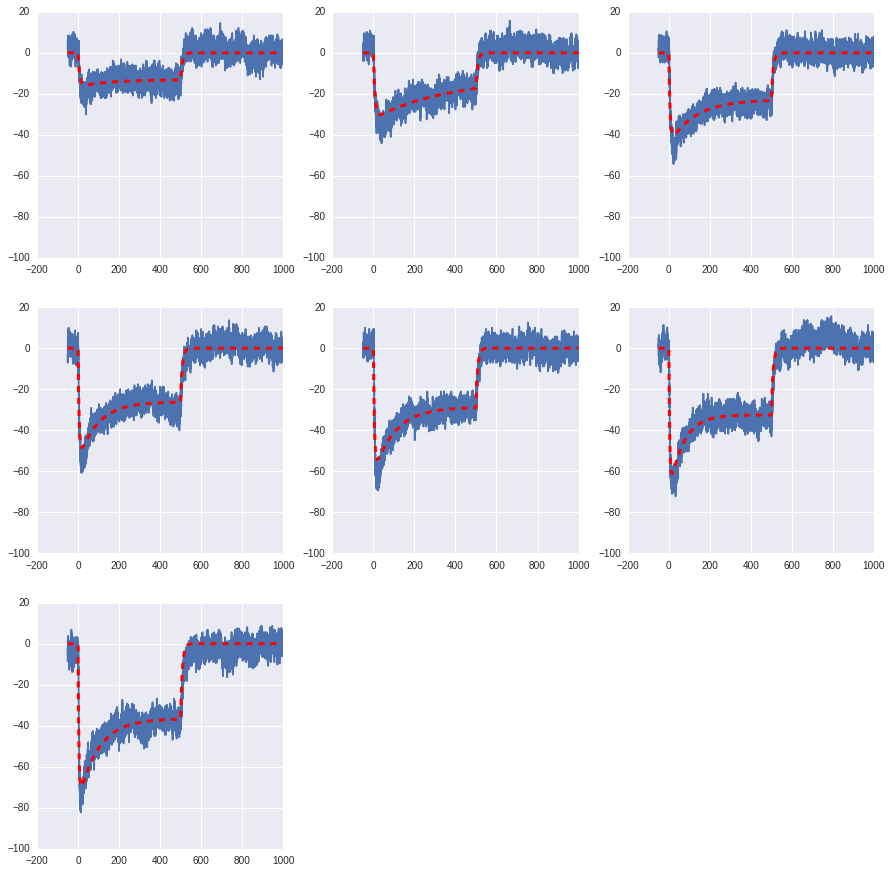

In [16]:
plt.figure(figsize=(15,15))

INVERT = -1

for i,e in enumerate(exps) :
    ax = plt.subplot(3,3,i+1)
    
    lightpower = powervalues[i]
    this_tau_on = func_on(lightpower,*popt_on)
    
    K_on[C,O] = 1.0/this_tau_on

    
    pulse_duration = e.pulse_end-e.pulse_start
    pulse = mt.Pulse(e.pulse_start,pulse_duration,10000)
    
#     plt.plot(e.x,e.y)
#     plt.plot(e.x, func_kd(e.x,popt_kd[i]),'--r',lw=2)
    
    plt.plot(e.x,INVERT*e.y,label=e.label);
    plt.plot(e.x,INVERT*func_kd(e.x,*popt_kd[i]),'r--',linewidth='3',label='fit');

    
    plt.axis([-200,1000,-100,20])
    

2


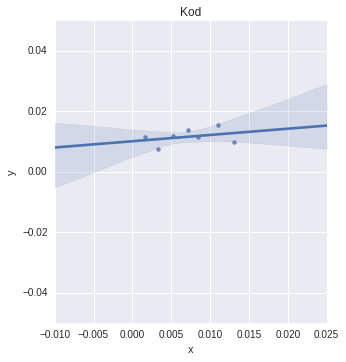

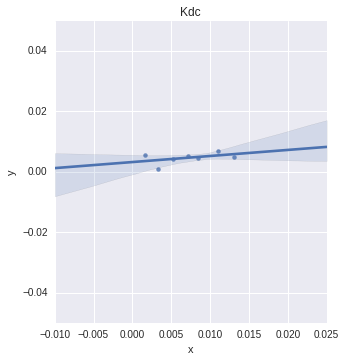

In [17]:
cols = popt_kd.shape[1]
print cols
for c in range(popt_kd.shape[1]):
    # plt.plot(powervalues,popt_kd,'o')
    df = pd.DataFrame()
    df['x'] = powervalues
    df['y'] = popt_kd[:,c]
#     print pd.ols(y=df['y'], x=df['x'])

    # from sklearn.linear_model import LinearRegression

    sns.lmplot('x', 'y', df, ci=95)
    plt.title(names[c])
    plt.ylim((-0.05,0.05))
#     plt.ylim((-10000,10000))
    


# Fitting with constraints 

In [161]:
### THE WORKING FUNCTION
# names = ['Kod','Kdo']
# def func_kd(t,kod,kdo):
#     K_on[O,D] = kod
#     K_off[O,D] = kod
#     K_on[D,O] = kdo
    
#     v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
#     return v[:,1]

### BENOIT's TEST
names = ['Kod','Kdc']
def func_kd(t,kod,kdc):
    K_on[O,D] = kod
    K_off[O,D] = kod
    K_on[D,C] = kdc
    K_off[D,C] = kdc
    v = odeint(mt.ode_model_generic, initial_condition, t, (K_off,K_on,pulse), hmax=10)
    return v[:,1]


# RESIDUAL REDEFINITION WITH PENALIZATION
def residuals(p,x,y):
    if any(p < 0):
        penalization = 10**3
    else:
        penalization = 0
    
    return y - func_kd(x,p[0],p[1]) + penalization

popt_kd = np.zeros((len(exps),2))
initial_condition = [norm_param,0,0]

print "WARGING : if measurement errors are not specified,\
confidence intervals do not make much sense\n"
# print "68% CONFIDENCE INTERVALS:"

for i,e in enumerate(exps) :
    
    lightpower = powervalues[i]
    this_tau_on = func_on(lightpower,*popt_on)
    K_on[C,O] = 1.0/this_tau_on
    pulse_duration = e.pulse_end-e.pulse_start
    pulse = mt.Pulse(e.pulse_start,pulse_duration,10000)
    
    popt_kd[i], pcov_kd = leastsq(func=residuals,
                                  args=(e.x, e.y),
                                  x0=(0.005,0.005),
                                  full_output=True)[0:2]
    
    print "curve %x" % i
    for j,p in enumerate(popt_kd[i]):
        print "{} : {:.2E} +/- {:.2E}".format(names[j], p, np.sqrt(pcov_kd[j,j]))
    print ""

for i in range(popt_kd.shape[1]):
    k_temp = np.mean(popt_kd[:,i])
    print "mean {} : {:.2E},\t tau = {:.2E} ms".format(names[i], k_temp, 1.0/k_temp)

WARGING : if measurement errors are not specified,confidence intervals do not make much sense

curve 0
Kod : 1.93E-02 +/- 3.88E-05
Kdc : 4.26E-04 +/- 4.45E-06

curve 1
Kod : 2.06E-02 +/- 1.91E-05
Kdc : 4.42E-05 +/- 8.21E-08

curve 2
Kod : 2.11E-02 +/- 1.61E-05
Kdc : 7.31E-04 +/- 4.01E-06

curve 3
Kod : 2.11E-02 +/- 1.39E-05
Kdc : 1.04E-03 +/- 3.75E-06

curve 4
Kod : 1.74E-02 +/- 9.48E-06
Kdc : 2.35E-04 +/- 3.42E-06

curve 5
Kod : 1.88E-02 +/- 6.58E-06
Kdc : 1.35E-03 +/- 5.17E-06

curve 6
Kod : 1.37E-02 +/- 5.73E-06
Kdc : 3.32E-04 +/- 8.31E-07

mean Kod : 1.89E-02,	 tau = 5.30E+01 ms
mean Kdc : 5.94E-04,	 tau = 1.68E+03 ms


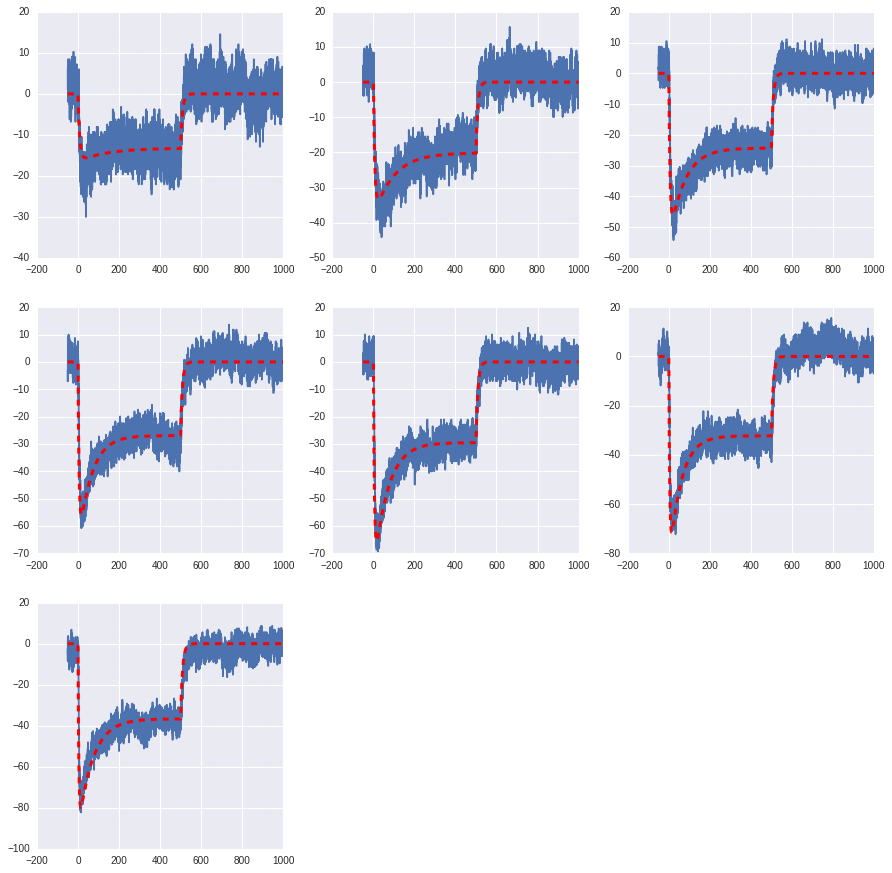

In [162]:
plt.figure(figsize=(15,15))

INVERT = -1

for i,e in enumerate(exps) :
    ax = plt.subplot(3,3,i+1)
    
    lightpower = powervalues[i]
    this_tau_on = func_on(lightpower,*popt_on)
    K_on[C,O] = 1.0/this_tau_on
    pulse_duration = e.pulse_end-e.pulse_start
    pulse = mt.Pulse(e.pulse_start,pulse_duration,10000)
      
    plt.plot(e.x,INVERT*e.y,label=e.label);
    plt.plot(e.x,INVERT*func_kd(e.x,*popt_kd[i]),'r--',linewidth='3',label='fit');


Exact  integral: 2.0
Approx integral1: 2.61625539344
Approx integral2: 2.00001961539


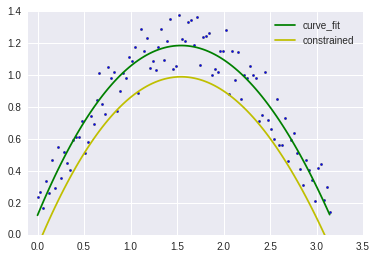

[[ 0.13953651 -0.35374435  0.22375986 -0.04128411]
 [-0.35374389  1.14036304 -0.81812345  0.16177164]
 [ 0.22375937 -0.81812294  0.6274615  -0.12938289]
 [-0.04128399  0.16177149 -0.12938285  0.02745592]]


In [134]:
### CONSTRAINTS IN FITTING

import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit, minimize, leastsq
from scipy.integrate import quad
from scipy import pi, sin
x = scipy.linspace(0, pi, 100)
y = scipy.sin(x) + (0. + scipy.rand(len(x))*0.4)
def func1(x, a0, a1, a2, a3):
    return a0 + a1*x + a2*x**2 + a3*x**3

# here you include the penalization factor
def residuals(p,x,y):
    integral = quad( func1, 0, pi, args=(p[0],p[1],p[2],p[3]))[0]
    penalization = abs(2.-integral)*10000
    return y - func1(x, p[0],p[1],p[2],p[3]) - penalization

popt1, pcov1 = curve_fit( func1, x, y )
popt2, pcov2 = leastsq(func=residuals, x0=(1.,1.,1.,1.), args=(x,y), full_output=True)[0:2]
y_fit1 = func1(x, *popt1)
y_fit2 = func1(x, *popt2)
plt.scatter(x,y, marker='.')
plt.plot(x,y_fit1, color='g', label='curve_fit')
plt.plot(x,y_fit2, color='y', label='constrained')
plt.legend(); plt.xlim(-0.1,3.5); plt.ylim(0,1.4)
print 'Exact  integral:',quad(sin ,0,pi)[0]
print 'Approx integral1:',quad(func1,0,pi,args=(popt1[0],popt1[1],
                                                popt1[2],popt1[3]))[0]
print 'Approx integral2:',quad(func1,0,pi,args=(popt2[0],popt2[1],
                                                popt2[2],popt2[3]))[0]
plt.show()

#Exact   integral: 2.0
#Approx integral1: 2.60068579748
#Approx integral2: 2.00001911981


In [155]:
x = np.array([1,-1])
y = np.array([1,1])
print any(x < 0)
print any(y < 0)



True
False


In [87]:
tau_offs

[6.5739275625875067,
 5.1719567031722651,
 6.8981053131389096,
 12.677108088193437,
 9.9983274570606575,
 10.787157955766178,
 13.256907048017961]